# Exploratory Data Analysis



## Setup



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import altair as alt

from statsmodels.graphics.mosaicplot import mosaic

df = pd.read_csv("diabetic_data.csv")

## Exploratory Visual Analysis for Research Questions

Variables w/ datatypes: 

 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              

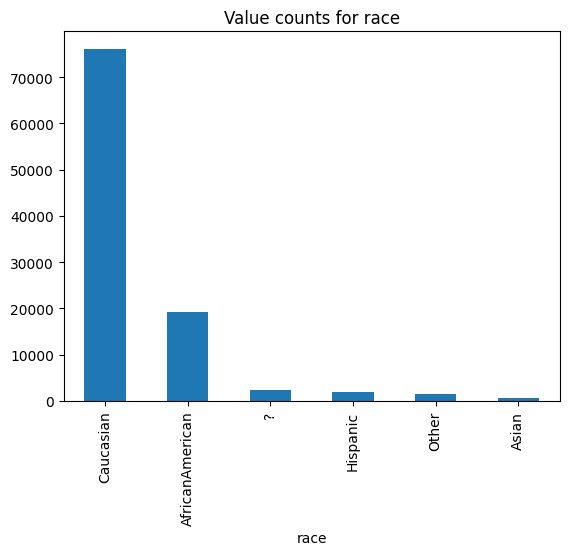

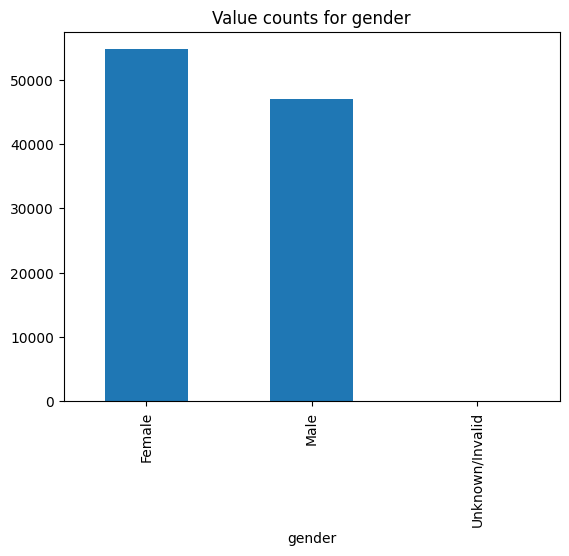

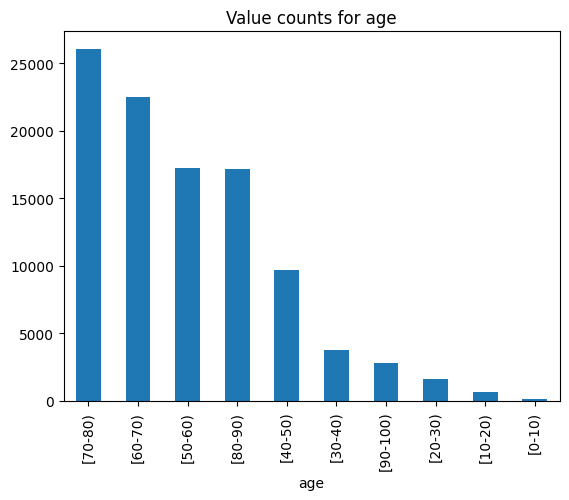

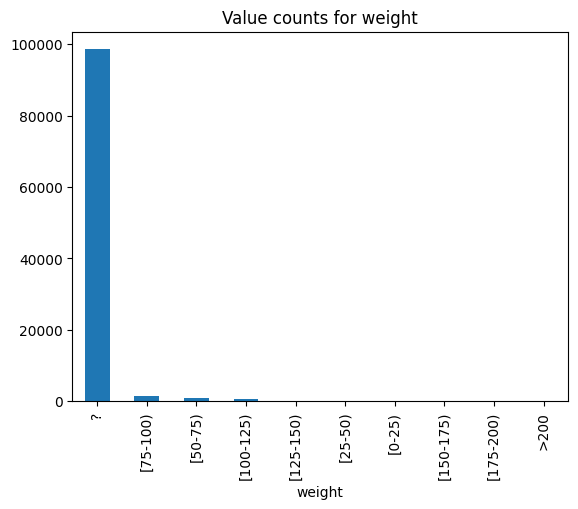

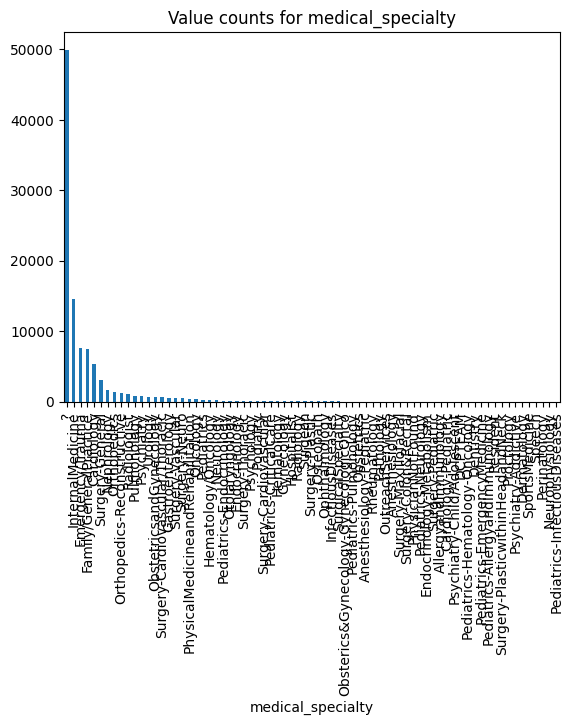

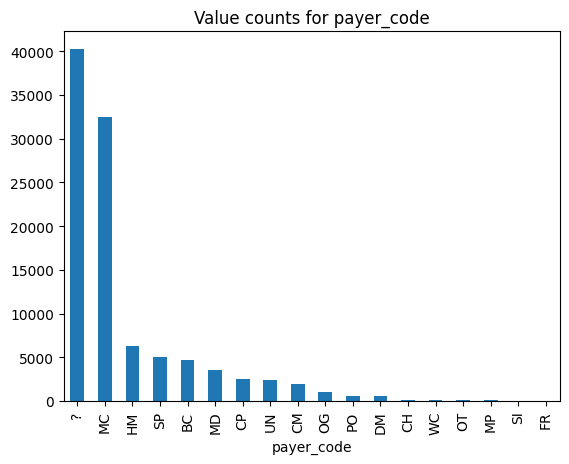

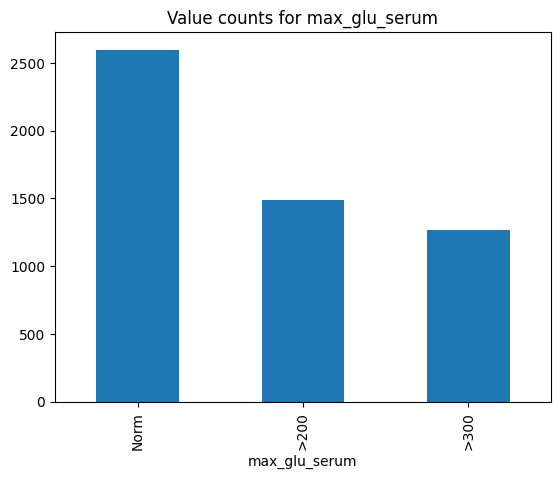

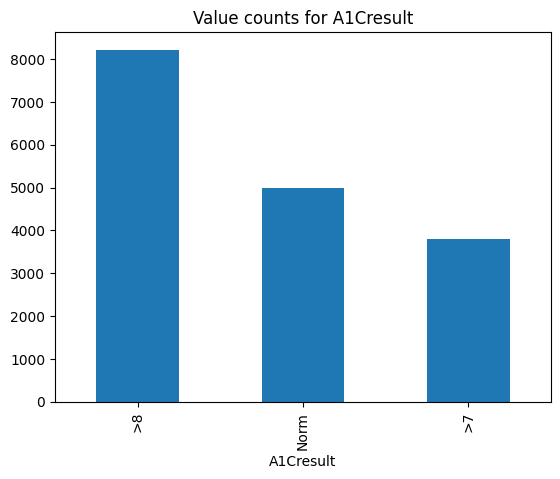

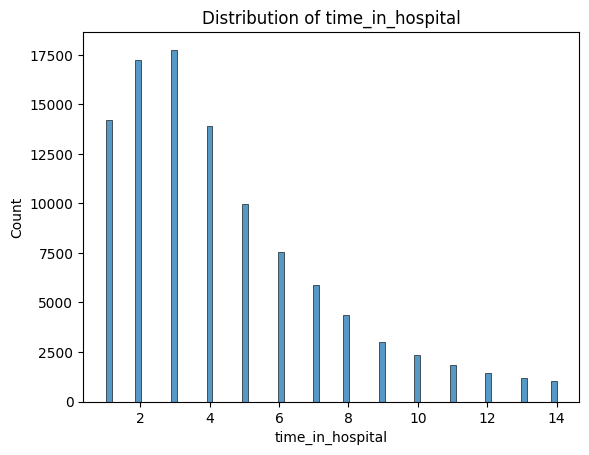

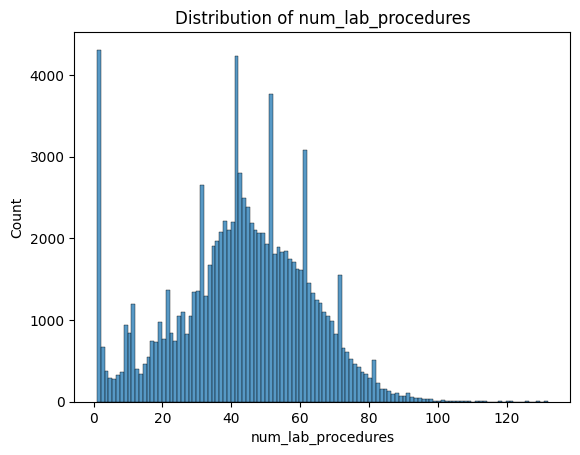

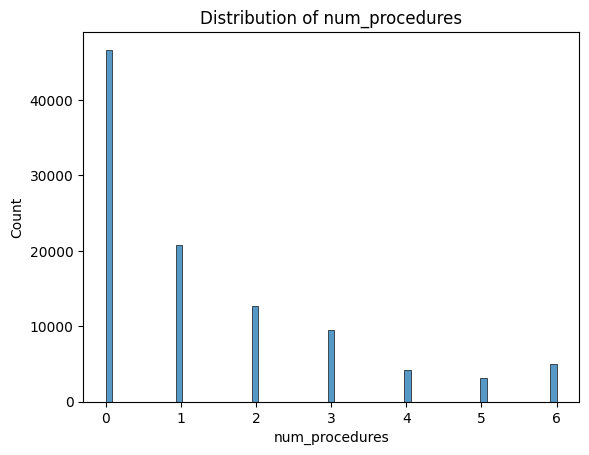

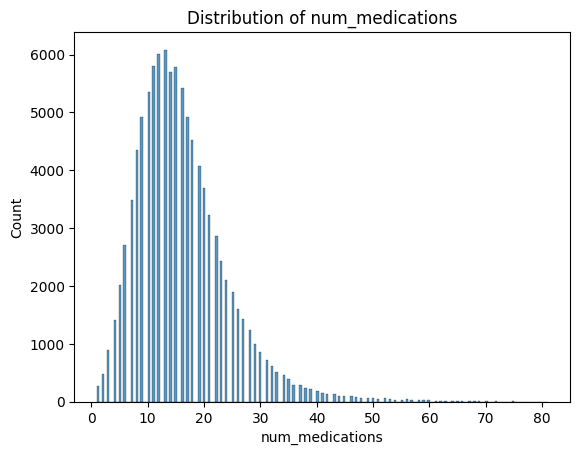

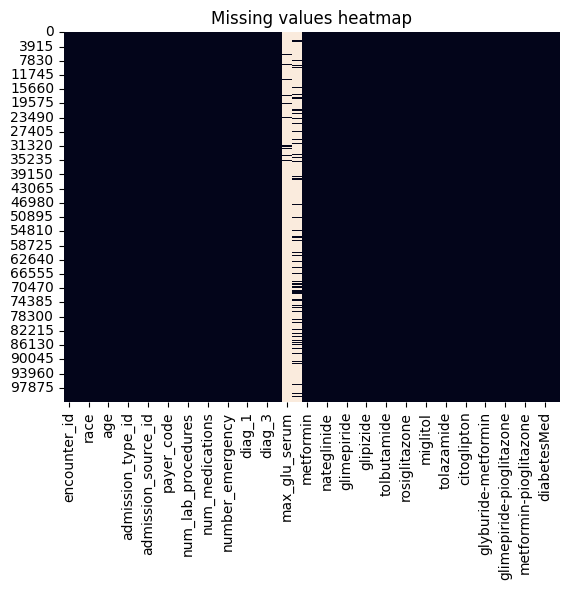

In [3]:
# initial exploration of the dataset
print("Variables w/ datatypes: \n\n", df.dtypes)

print("\n\n\n\nSummary statistics:\n\n", df.describe())

print("\n\n\n\nAre there duplicate entries for unique identifier: \n")

print("\nEncounter ID:", df.duplicated(subset='encounter_id').unique())

categorical_cols = ['race', 'gender', 'age', 'weight', 'medical_specialty', 'payer_code', 'max_glu_serum', 'A1Cresult']
for col in categorical_cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Value counts for {col}')
    plt.show()

numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']
for col in numerical_cols:
    sns.histplot(df[col].dropna())
    plt.title(f'Distribution of {col}')
    plt.show()

sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing values heatmap')
plt.show()


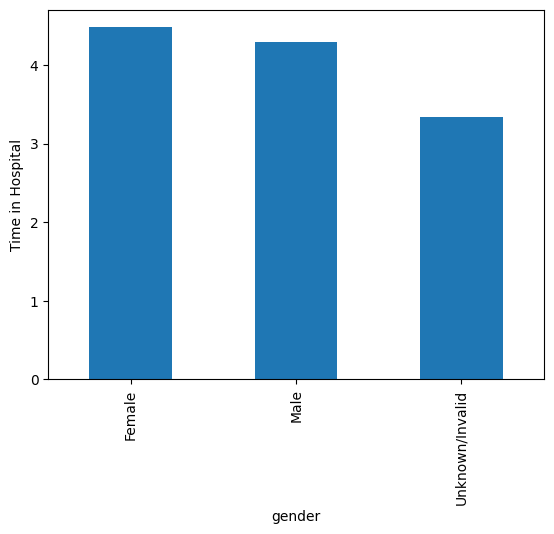

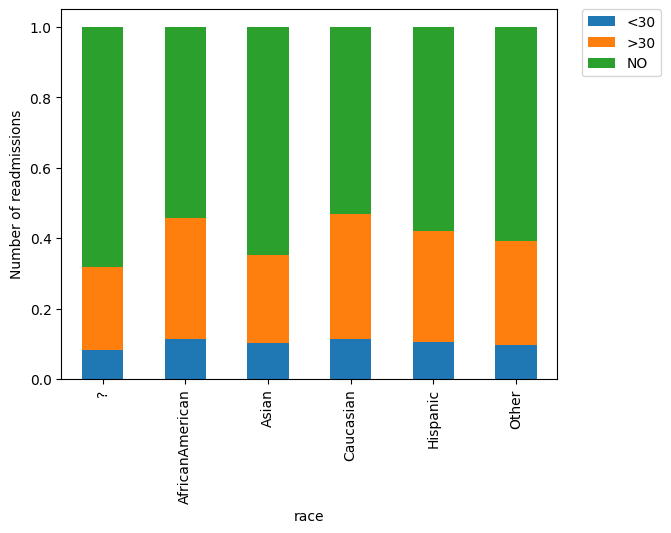

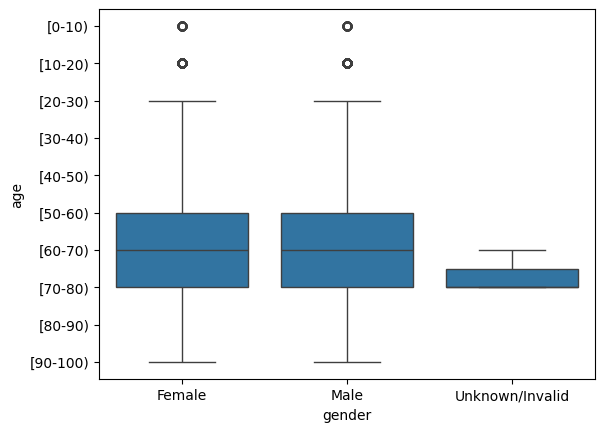

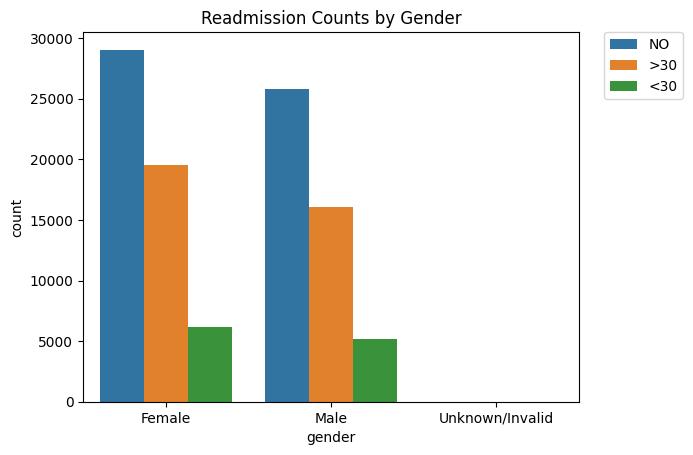

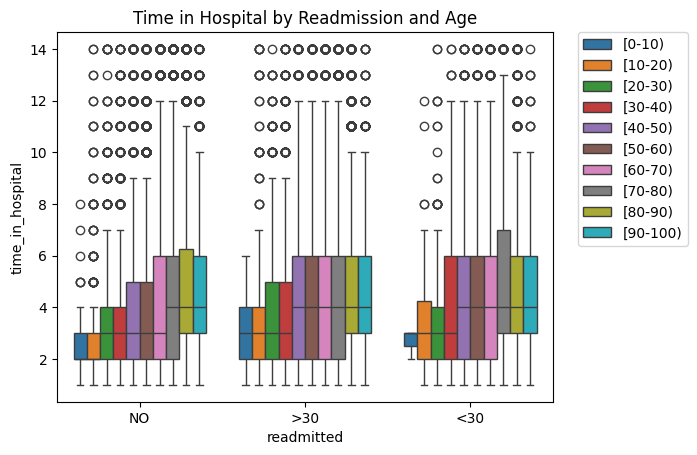

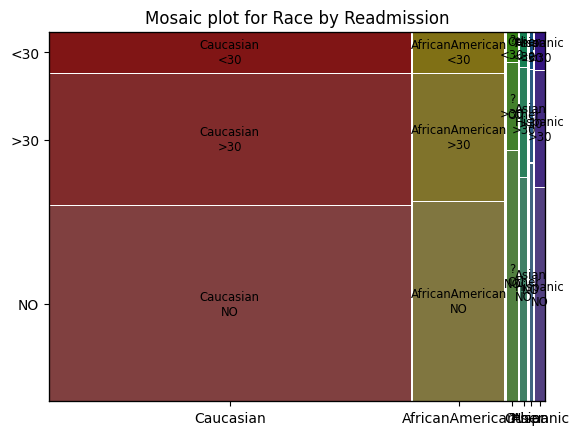

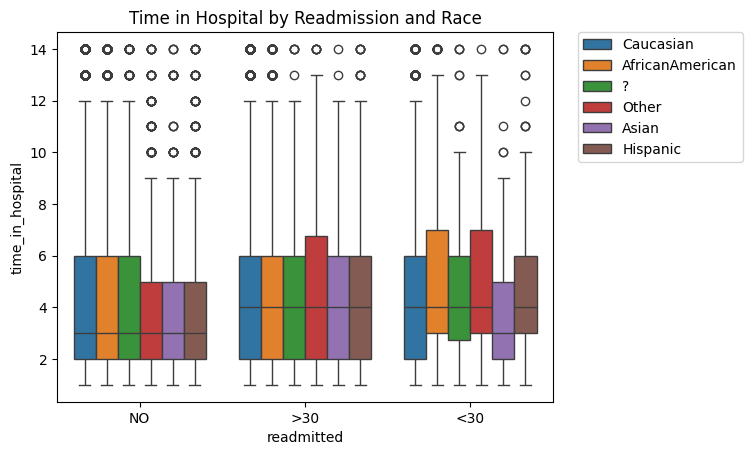

In [4]:
# Research Question Origin/Alters/Genderabhängige Unterschiede

df.groupby('gender')['time_in_hospital'].mean().plot(kind='bar')
plt.ylabel('Time in Hospital')
plt.show()

df.groupby('race')['readmitted'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.ylabel('Number of readmissions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

sns.boxplot(x='gender', y='age', data=df)
plt.show()


# Example: Count plot of readmissions by gender
sns.countplot(x='gender', hue='readmitted', data=df)
plt.title('Readmission Counts by Gender')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

sns.boxplot(x='readmitted', y='time_in_hospital', hue='age', data=df)
plt.title('Time in Hospital by Readmission and Age')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Example: Mosaic plot (requires statsmodels)

mosaic(df, ['race', 'readmitted'])
plt.title('Mosaic plot for Race by Readmission')
plt.show()

# Example: Boxplot comparing time in hospital by readmission and race
sns.boxplot(x='readmitted', y='time_in_hospital', hue='race', data=df)
plt.title('Time in Hospital by Readmission and Race')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()






In [43]:
import pandas as pd
import plotly.graph_objects as go

# --- columns (rename to yours) ---
A = "admission_source_id"
B = "discharge_disposition_id"
C = "readmitted"              # your 3rd target
pct = 0.01                    # 1% threshold (per column)
ELSE = "Other"

def bucket_small(df, col, pct=0.01, else_label="Other"):
    s = df[col].astype(str).fillna("Unknown")
    vc = s.value_counts()
    total = len(s)
    small_vals = vc[vc / total < pct].index
    return s.where(~s.isin(small_vals), else_label)

# 1) Collapse rare categories per column
df2 = df.copy()
for col in [A, B, C]:
    df2[col] = bucket_small(df2, col, pct=pct, else_label=ELSE)

# 2) Aggregate flows for A→B and B→C
ab = (df2[[A, B]].groupby([A, B]).size()
      .reset_index(name="value"))
bc = (df2[[B, C]].groupby([B, C]).size()
      .reset_index(name="value"))

# 3) Build node lists (keep layers distinct to avoid loops)
A_vals = sorted(ab[A].unique().tolist())
B_vals = sorted(pd.Index(ab[B]).union(bc[B]).unique().tolist())
C_vals = sorted(bc[C].unique().tolist())

labels_pretty = A_vals + B_vals + C_vals

# index offsets
a_off = 0
b_off = len(A_vals)
c_off = b_off + len(B_vals)
a_idx = {v: a_off + i for i, v in enumerate(A_vals)}
b_idx = {v: b_off + i for i, v in enumerate(B_vals)}
c_idx = {v: c_off + i for i, v in enumerate(C_vals)}

# links
src =  ab[A].map(a_idx).tolist() +  bc[B].map(b_idx).tolist()
tgt =  ab[B].map(b_idx).tolist() +  bc[C].map(c_idx).tolist()
val =  ab["value"].tolist()      +  bc["value"].tolist()

# pin three vertical columns
xpos = [0]*len(A_vals) + [0.5]*len(B_vals) + [1]*len(C_vals)

fig = go.Figure(go.Sankey(
    node=dict(label=labels_pretty, pad=15, thickness=14, x=xpos, y=None),
    link=dict(source=src, target=tgt, value=val)
))
fig.update_layout(title="Admissions → Discharge → Outcome (rare <1% grouped as Other)")
fig.show()


## Within each primary diagnosis group, what are the top independent predictors of a readmission?

### Data preperation


In [6]:
#print(df["diag_1"].unique())
ICD9_CHAPTERS = [
    (1,   139,  1,  "Infectious and parasitic diseases"),
    (140, 239,  2,  "Neoplasms"),
    (240, 279,  3,  "Endocrine, nutritional & metabolic diseases; immunity disorders"),
    (280, 289,  4,  "Diseases of the blood & blood-forming organs"),
    (290, 319,  5,  "Mental disorders"),
    (320, 389,  6,  "Diseases of the nervous system & sense organs"),
    (390, 459,  7,  "Diseases of the circulatory system"),
    (460, 519,  8,  "Diseases of the respiratory system"),
    (520, 579,  9,  "Diseases of the digestive system"),
    (580, 629, 10,  "Diseases of the genitourinary system"),
    (630, 679, 11,  "Complications of pregnancy, childbirth & the puerperium"),
    (680, 709, 12,  "Diseases of the skin & subcutaneous tissue"),
    (710, 739, 13,  "Diseases of the musculoskeletal system & connective tissue"),
    (740, 759, 14,  "Congenital anomalies"),
    (760, 779, 15,  "Certain conditions originating in the perinatal period"),
    (780, 799, 16,  "Symptoms, signs & ill-defined conditions"),
    (800, 999, 17,  "Injury & poisoning"),
]

diags = ["diag_1", "diag_2", "diag_3"]

edges  = [ICD9_CHAPTERS[0][0]] + [hi for (_, hi, _, _) in ICD9_CHAPTERS]  # [1, 139, 239, ..., 999]
labels = [grp for (_, _, grp, _) in ICD9_CHAPTERS]
for diag in diags:
    codes = pd.to_numeric(df[diag], errors="coerce")
    codes = np.floor(codes)
    df[diag+"_chapter"] = pd.cut(
        codes,
        bins=edges,
        labels=labels,
        include_lowest=True,
        right=True,           # intervals are (prev_edge, edge], e.g., (139,239]
        ordered=True
    )

    chapter_name_map = {grp: name for (_, _, grp, name) in ICD9_CHAPTERS}
    df[diag+"_chapter_name"] = df[diag+"_chapter"].map(chapter_name_map)

df.to_csv("diabetic_data_with_chapters.csv", index=False)


### Exploration

In [7]:
import pandas as pd
import altair as alt

CATEGORY_COL = "diag_1_chapter"   # your categorical x (e.g., ICD-9 chapter 1..17)
VALUE_COL    = "readmitted" # the single numeric variable to bucket
# ------------------------------------------
chapter_order = list(range(1, 18))

# 1) Build buckets: 1 (<30), 2 (>=30), 3 (none)
map_dict = {"<30": 1, ">30": 2, "NO": 3}
df["_bucket"] = df[VALUE_COL].map(map_dict)


agg = (df.groupby([CATEGORY_COL, "_bucket"])
         .size()
         .reset_index(name="count")
         .rename(columns={CATEGORY_COL: "category", "_bucket": "bucket"}))

agg = (df.groupby([CATEGORY_COL, "_bucket"])
         .size()
         .reset_index(name="count")
         .rename(columns={CATEGORY_COL: "category", "_bucket": "bucket"}))


cats = sorted(agg["category"].dropna().unique().tolist())
all_idx = pd.MultiIndex.from_product([cats, [1,2,3]], names=["category","bucket"])
agg = (agg.set_index(["category","bucket"])
          .reindex(all_idx, fill_value=0)
          .reset_index())

agg["category"] = pd.Categorical(agg["category"], categories=cats, ordered=True)
agg["bucket"]   = pd.Categorical(agg["bucket"],   categories=[1,2,3], ordered=True)

chart = (
    alt.Chart(agg, title="Counts by ICD-9 Category and Readmission")
      .transform_calculate(
          bucket_label="datum.bucket == 1 ? '>30' : datum.bucket == 2 ? '<30' : 'NO'"
      )
      .mark_bar()
      .encode(
          x=alt.X("category:N", title="Category"),
          xOffset=alt.XOffset("bucket:N", sort=[1,2,3]),
          y=alt.Y("count:Q", title="Count"),
          color=alt.Color("bucket_label:N", title="Readmission", sort=[">30", "<30", "NO"]),
          tooltip=["category:N", "bucket_label:N", "count:Q"]
      )
      .properties(width=25*len(chapter_order), height=320)

)


icd9_ranges = {
    1:  "001–139  Infectious & parasitic diseases",
    2:  "140–239  Neoplasms",
    3:  "240–279  Endocrine/metabolic & immunity",
    4:  "280–289  Blood & blood-forming organs",
    5:  "290–319  Mental disorders",
    6:  "320–389  Nervous system & sense organs",
    7:  "390–459  Circulatory system",
    8:  "460–519  Respiratory system",
    9:  "520–579  Digestive system",
    10: "580–629  Genitourinary system",
    11: "630–679  Pregnancy/childbirth/puerperium",
    12: "680–709  Skin & subcutaneous tissue",
    13: "710–739  Musculoskeletal & connective tissue",
    14: "740–759  Congenital anomalies",
    15: "760–779  Perinatal conditions",
    16: "780–799  Symptoms/signs/ill-defined",
    17: "800–999  Injury & poisoning",
}

legend_df = pd.DataFrame({
    "chapter": chapter_order,
    "label": [f"{c} — {icd9_ranges[c]}" for c in chapter_order]
})

# A neat text panel; you can tweak width to fit your layout
side_labels = (
    alt.Chart(legend_df)
      .mark_text(align="left", baseline="top")
      .encode(
        x=alt.value(0),
          y=alt.Y("chapter:O", sort=chapter_order, axis=None),  # one line per chapter
          text="label:N"
      )
      .properties(width=300, height=320, title="ICD-9 Chapter Reference")
)
# --- COMBINE: your chart + the side reference (colors unchanged) ---
final_chart = alt.hconcat(chart, side_labels).resolve_legend(color="independent")
final_chart



C:\Users\rauchegger\AppData\Local\Temp\ipykernel_23632\2753225880.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\rauchegger\AppData\Local\Temp\ipykernel_23632\2753225880.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



alt.HConcatChart(...)

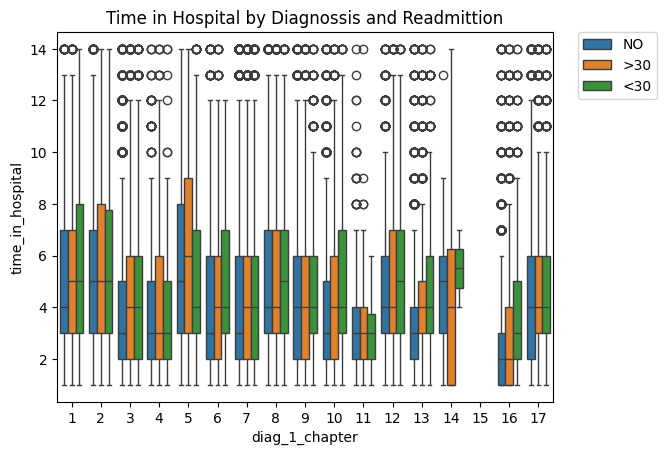

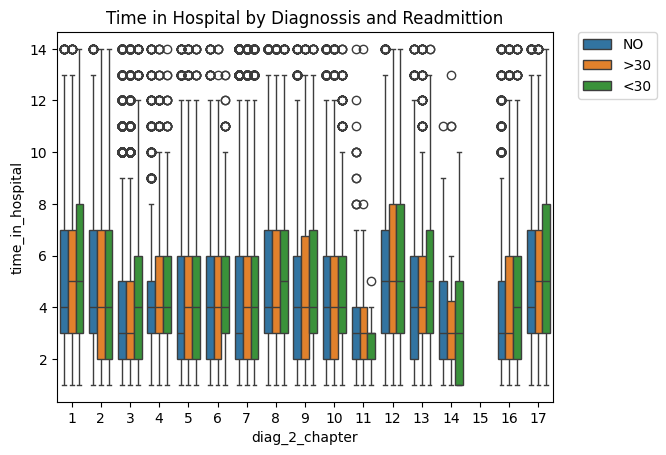

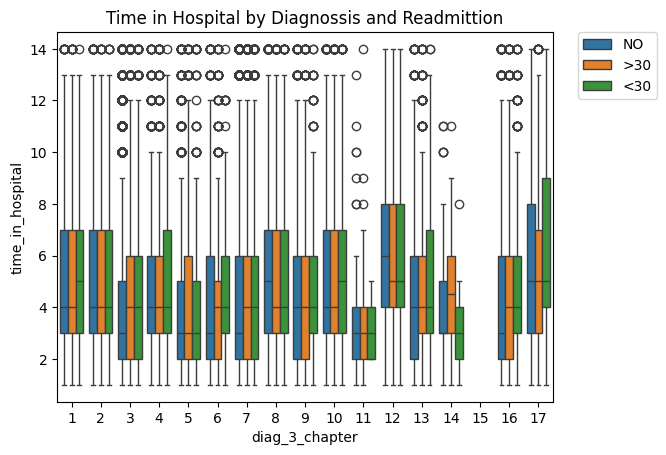

In [24]:
sns.boxplot(x='diag_1_chapter', y='time_in_hospital', hue='readmitted', data=df)
plt.title('Time in Hospital by Diagnossis and Readmittion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
sns.boxplot(x='diag_2_chapter', y='time_in_hospital', hue='readmitted', data=df)
plt.title('Time in Hospital by Diagnossis and Readmittion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
sns.boxplot(x='diag_3_chapter', y='time_in_hospital', hue='readmitted', data=df)
plt.title('Time in Hospital by Diagnossis and Readmittion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

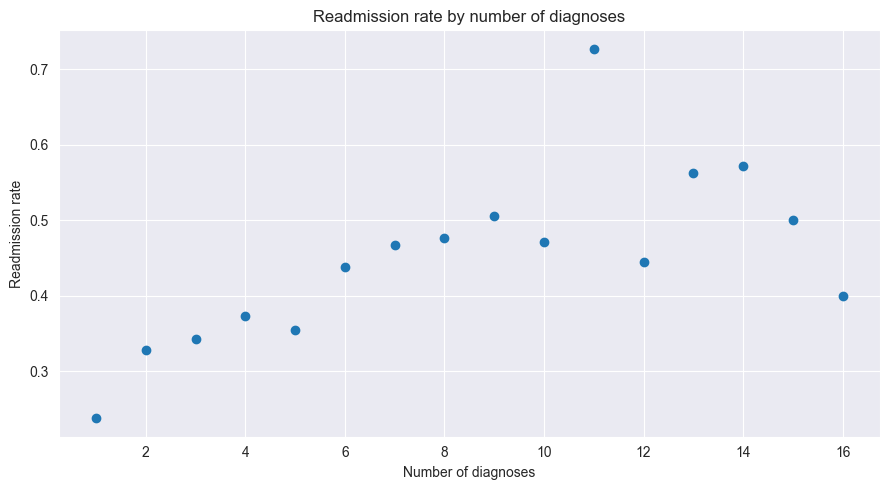

In [41]:
y = (df["readmitted"].astype(str).str.strip().str.lower() != "no").astype(int)
x = df["number_diagnoses"].astype(int)

# Aggregate rate by each count
rate_by_count = pd.DataFrame({
    "number_diagnoses": x,
    "readmitted": y
}).groupby("number_diagnoses", as_index=False)["readmitted"].mean()

# Plot (bars)
plt.figure(figsize=(9,5))
plt.scatter(rate_by_count["number_diagnoses"], rate_by_count["readmitted"])
plt.xlabel("Number of diagnoses")
plt.ylabel("Readmission rate")
plt.title("Readmission rate by number of diagnoses")
plt.tight_layout()
plt.savefig("readmit_rate_by_num_diagnoses_bar.png", dpi=200)
plt.show()

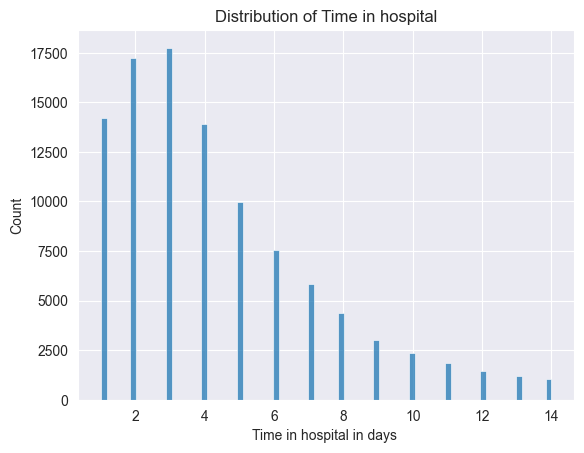

In [46]:
numerical_cols = ['time_in_hospital']
for col in numerical_cols:
    sns.histplot(df[col].dropna())
    plt.title(f'Distribution of Time in hospital')
    plt.xlabel("Time in hospital in days ")
    plt.show()